REMEMBER TO SWITCH TO (ai) CONDA BRANCH

In [41]:
import sys
import os
import numpy as np
from random import random as rand
import random
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch
import matplotlib.pyplot as plt
import torch.cuda as cuda
from tqdm import tqdm

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device name: ", cuda.get_device_name(device))

Device name:  GeForce GTX 1060 6GB


In [43]:
# hyperparameters etc.
TRAINSIZE = 8000
TESTSIZE = 100
LUMA = np.array([0.2126,0.7152,0.0722])
EPOCHS = 4
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
# NUM_WORKERS = 8 # 3700x = 8 cores
torch.manual_seed(0)
np.random.seed(0)
# random.seed(0)

In [44]:
#helper functions
def get_training_data(trainsize):
    dimsize = int(trainsize**(1/3)) + 1
    if dimsize > 256:
        print("WARNING: training size truncated to max RGB range.")
        dimsize = 256
    size = np.linspace(0,255,dimsize, dtype="float32")
    trainvalues = np.vstack(np.meshgrid(size,size,size)).reshape(3,-1).T # create 1D array of 3D coords
    np.random.shuffle(trainvalues)
    trainlabels = np.array([1 if np.dot(LUMA,data)/255 > 0.5 else 0 for data in trainvalues])
    # traindata = np.hstack((trainvalues,np.atleast_2d(trainlabels).T))
    return trainvalues, trainlabels

def get_testing_data(testsize):
    testvalues = np.floor(np.array([[rand()*255,
                            rand()*255,
                            rand()*255] for i in range(testsize)]))
    testlabels = np.array([1 if np.dot(LUMA,data)/255 > 0.5 else 0 for data in testvalues])
    # testdata = np.hstack((testvalues,np.atleast_2d(testlabels).T))
    return testvalues, testlabels

def plot_loss_curve(running_loss):
    plt.plot(running_loss)
    plt.show()

def display_colors(values, labels, model=None, test=False):
    samples = np.array(random.sample(list(enumerate(values)), 5),dtype=object)
    if test:
        fig, axs = plt.subplots(2,5, figsize=(10,2))
        neural_output = model(torch.from_numpy(np.array(samples[:,1].tolist())).to(device).float())
        _, predicted = torch.max(neural_output.data, 1)
    else:
        fig, axs = plt.subplots(1,5, figsize=(10,1))
    text = ["these","are","the","correct","labels"]
    textn = ["these","are","the","neural","labels"]
    if test:
        for i, ax in enumerate(axs.reshape(-1)):
            if i < 5:
                ax.text(0,0,text[i],size=30,ha="center",va="center",bbox=dict(
                    boxstyle="square",
                    color=tuple(samples[i][1]/255)
                    ),
                    color=((0,0,0) if labels[samples[i][0]] else (1,1,1))
                )
                ax.axis("off")
            else:
                ax.text(0,0,textn[i-5],size=30,ha="center",va="center",bbox=dict(
                    boxstyle="square",
                    color=tuple(samples[i-5][1]/255)
                    ),
                    color=((0,0,0) if predicted[i-5] else (1,1,1))
                )
                ax.axis("off")
    else:
        for i, ax in enumerate(axs):
            ax.text(0,0,text[i],size=30,ha="center",va="center",bbox=dict(
                boxstyle="square",
                color=tuple(samples[i][1]/255)
                ),
                color=((0,0,0) if labels[samples[i][0]] else (1,1,1))
            )
            ax.axis("off")
    fig.tight_layout()
    plt.show()

train data shape:  (8000, 3)
test data shape:  (100, 3)


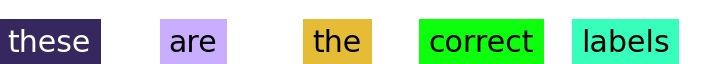

In [45]:
#data generation
traindata = get_training_data(TRAINSIZE)
testdata = get_testing_data(TESTSIZE)
print("train data shape: ",traindata[0].shape)
print("test data shape: ",testdata[0].shape)
display_colors(traindata[0],traindata[1])


In [46]:
#model architecture
class RGBDataset(Dataset):
    def __init__(self,data):
        self.features = torch.from_numpy(data[0])
        self.labels = torch.from_numpy(data[1])

    # iterator; ith element of dataset (e.g. dataset[i])
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
        
    def __len__(self):
        return self.features.shape[0]

train_set = RGBDataset(traindata)
test_set  = RGBDataset(testdata)

dataloader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,2)
        ).to(device)
    
    def forward(self, x):
        return self.layers(x)



Epoch 1 done...
Epoch 2 done...
Epoch 3 done...
Epoch 4 done...


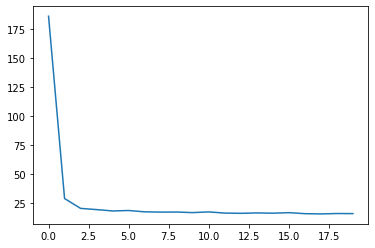

In [47]:
#training
mlp = MLP()
mlp.to(device)
n_iterations = len(train_set)//BATCH_SIZE
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(),lr=LEARNING_RATE)

running_loss = []
for epoch in range(EPOCHS):
    current_loss = 0.0
    for batch, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = mlp(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

        if (batch) % 50 == 49:
            # print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch+1, batch, loss.item()))
            running_loss.append(current_loss)
            tmp_loss = current_loss
            current_loss = 0.0
    print('Epoch %d done...' % (epoch+1))
    tmp_loss = 0.0
plot_loss_curve(running_loss)

0
1
2
3
4
5
6
7
8
9


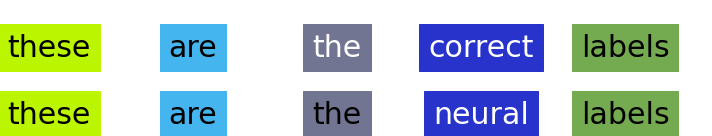

test accuracy on 100 samples: 77.000000 %


In [48]:
#testing
correct = 0
total = 0
with torch.no_grad():
    for batch, (inputs, labels) in enumerate(testloader):
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        outputs = mlp(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    display_colors(testdata[0],testdata[1],mlp,test=True)
acc  = correct/total
print('test accuracy on %d samples: %f %%' % (TESTSIZE,acc*100))